<h2> Importing Libraries

In [2]:
!pip install torch torchvision torchaudio -q

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2, glob, numpy as np, pandas as pd
import torchvision.transforms as transforms
import torch.utils.data
import pandas as pd

In [4]:
from torchvision import transforms,models,datasets
from PIL import Image
from torch import optim
from glob import glob
from torch.utils.data import DataLoader

<h2> Data Preprocessing

In [5]:
img_names = '/kaggle/input/facebook-hateful-meme-captions/img/img'
train_data_dir = '/kaggle/input/facebook-hateful-meme-captions/train.csv'
valid_data_dir = '/kaggle/input/facebook-hateful-meme-captions/dev.csv'

train_df = pd.read_csv(train_data_dir)
test_df = pd.read_csv(valid_data_dir)

In [6]:
def data_preprocess(df1):
    #making a list of all images
    files = glob(img_names, recursive = True)
    for i in range(len(files)):
        files[i] = files[i].strip(img_names)

    #fetching the labels for each img

#     df1['label'] = df1['label'].str.lower()
    df1['text'] = df1['text'].str.lower()

    #getting a list of all img names that are offensive and non offensive
    off = [x for x in df1['img'] if df1.loc[df1['img'] == x, 'label'].values[0] == 1]
    non_off = [y for y in df1['img'] if df1.loc[df1['img'] == y, 'label'].values[0] == 0]


    #adding the file path to the off and non-off img names to locate and open from original path
    for i in range(len(off)):
        off[i] = '/kaggle/input/facebook-hateful-meme-captions/img/' + off[i]

    for i in range(len(non_off)):
        non_off[i] = '/kaggle/input/facebook-hateful-meme-captions/img/' + non_off[i]
    return off, non_off

In [7]:
df1 = test_df
# non_off = [y for y in df1['image_name'] if df1.loc[df1['image_name'] == y, 'label'].values[0] == 'Non-offensiv']
# off =  [x for x in df1['image_name'] if df1.loc[df1['image_name'] == x, 'label'].values[0] == 'offensive']

In [8]:
# data_preprocess(df1)

In [9]:
class MyData():
    def __init__(self, X, Y):
        self.fpaths = X + Y
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                              std=[0.229, 0.224, 0.225])
        self.resize = transforms.Resize((224, 224))  # Ensure images are resized to 224x224
        self.targets = torch.tensor([1 for _ in X] + [0 for _ in Y]).unsqueeze(1)
        self.placeholder = torch.zeros(3, 224, 224)  # Placeholder image

    def __len__(self):
        return len(self.fpaths)
    
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        
        # Read the image and convert to RGB
        im = cv2.imread(f)
        if im is None:
            print(f"Failed to read image from path: {f}. Using placeholder.")
            im = self.placeholder
        else:
            im = im[:, :, ::-1]  # Convert BGR to RGB
            im = cv2.resize(im, (224, 224))  # Resize to ensure consistency
            im = transforms.ToTensor()(im)  # Convert to tensor and scale to [0, 1]
            im = self.resize(im)  # Resize to 224x224 to ensure consistency
            im = self.normalize(im)
        
        return im.float().to('cuda'), target.float().to('cuda')

<h2> Classifying using Resnet18

In [10]:
import torchvision.models as models
device  = 'cuda'

def get_model():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 1),
    nn.Sigmoid())
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

In [11]:
!pip install torch_summary
from torchsummary import summary
model, criterion, optimizer = get_model()
summary(model, torch.zeros(1,3,224,224))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

In [12]:

def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [13]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [14]:
def get_data():
    train = MyData(off, non_off)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True,
                                          drop_last = True)
    val = MyData(off_test, non_off_test)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [15]:
off, non_off = data_preprocess(train_df) 
off_test, non_off_test = data_preprocess(test_df)

In [16]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [17]:
train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(6):
    print(f" epoch {epoch + 1}/6")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

 epoch 1/6
 epoch 2/6
 epoch 3/6
 epoch 4/6
 epoch 5/6
 epoch 6/6


In [18]:
train_losses

[0.6549751054565861,
 0.6387929330456932,
 0.6333875818072625,
 0.6268458233689362,
 0.625140251528542,
 0.6182060189966886]

In [19]:
val_accuracies

[0.5166666666666667, 0.5104166666666666, 0.50625, 0.5, 0.5020833333333333, 0.5]

In [20]:
train_accuracies

[0.6445754716981132,
 0.651061320754717,
 0.6471698113207547,
 0.6602594339622642,
 0.6607311320754717,
 0.6709905660377359]

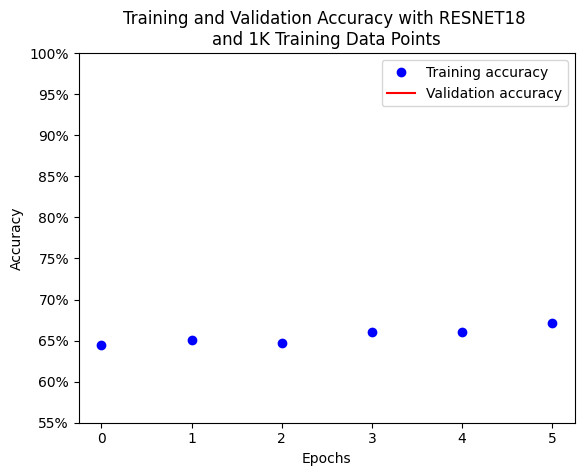

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import FuncFormatter

epochs = np.arange(0,6)
# Custom formatter for y-axis ticks
def percent_formatter(x, pos):
    return '{:.0f}%'.format(x * 100)

# Plotting
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))
plt.title('Training and Validation Accuracy with RESNET18 \nand 1K Training Data Points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.55, 1)
plt.legend()
plt.grid(False)
plt.show()

<h2> Classifying using VGG16

In [22]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [23]:
import torchvision.models as models
device  = 'cuda'
def get_model():
    model = models.vgg16(pretrained=True)  # Load a pre-trained VGG16 model
    for param in model.parameters():
        param.requires_grad = False  # Freeze all parameters
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(nn.Flatten(),
                                    nn.Linear(512, 128),
                                    nn.Dropout(0.2),
                                    nn.Linear(128,1),
                                    nn.Sigmoid())
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
    return model.to(device), loss_fn, optimizer
# Example usage
model = get_model()
model

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 157MB/s] 


(VGG(
   (features): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU(inplace=True)
     (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU(inplace=True)
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (6): ReLU(inplace=True)
     (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (8): ReLU(inplace=True)
     (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): ReLU(inplace=True)
     (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (13): ReLU(inplace=True)
     (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (15): ReLU(inplace=True)
     (16): MaxPool2d(kernel_size=2, stride=2, pa

In [24]:
from torchsummary import summary
model, criterion, optimizer = get_model()
summary(model, torch.zeros(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

In [25]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()


In [26]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [27]:
def get_data():
    train = MyData(off, non_off)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True,
                                          drop_last = True)
    val = MyData(off_test, non_off_test)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [28]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [29]:
train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(3):
    print(f" epoch {epoch + 1}/3")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)
    

 epoch 1/3
 epoch 2/3
 epoch 3/3


In [30]:
train_losses


[0.6464265469110237, 0.6268213951362753, 0.6203443662175593]

In [31]:
train_accuracies


[0.6512971698113208, 0.6621462264150944, 0.6655660377358491]

In [32]:
val_accuracies


[0.5, 0.4875, 0.5]

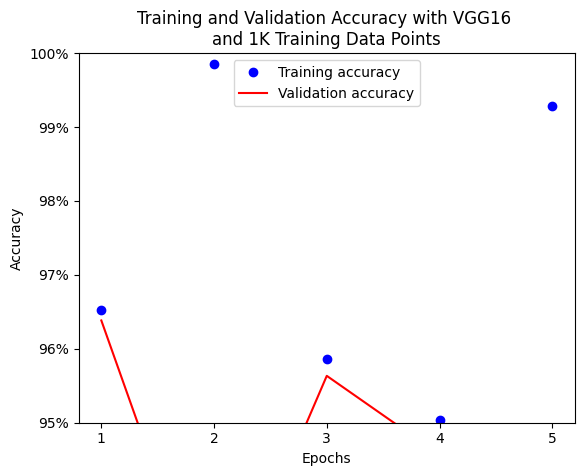

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import FuncFormatter

# Example data
epochs = np.arange(1, 6)
train_accuracies = np.random.uniform(0.95, 1.0, size=len(epochs))
val_accuracies = np.random.uniform(0.9, 1.0, size=len(epochs))

# Custom formatter for y-axis ticks
def percent_formatter(x, pos):
    return '{:.0f}%'.format(x * 100)

# Plotting
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))
plt.title('Training and Validation Accuracy with VGG16 \nand 1K Training Data Points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95, 1)
plt.legend()
plt.grid(False)
plt.show()